# Crop_he5_h5
---
Notebook to recursively crop large he5 files. The AU_SI12 files are large: 131 MB per day, storing both N and S hemisphere TB data across several frequencies, as well as other data such as ice motion. 

This notebook allows you to open an he5 file, specify a list of the data fields to carry over to a cropped version of the file. It then saves a new .h5 file with only specified fields, and deletes the original .he5 file. 

## Import packages

In [46]:
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

### Functions to open he5 files and write to cropped h5 files

In [78]:
def read_AMSRTB_he5(file = '/Users/mackenziejewell/Downloads/AMSR_U2_L3_SeaIce12km_B04_20130301.he5',
                    hemisphere = 'N'):

    f = h5py.File(file,'r')

    # grab resolution from file name
    resolution = file.split('SeaIce')[-1].split('_')[0]
    resolution = resolution.split('km')[0].zfill(2)+'km' # zfill to 2-digit res

    # navigate to data of chosen hemisphere
    F = f['HDFEOS']['GRIDS'][f'{hemisphere}pPolarGrid{resolution}']

    # create dictionary to save data
    data = {}

    data['lat'] = F['lat'][:].astype(dtype=np.int16)
    data['lon'] = F['lon'][:].astype(dtype=np.int16)

    # save all data fields
    for item in list(F['Data Fields'].items()):
        data[item[0]] = F['Data Fields'][item[0]][:].astype(dtype=np.int16)
        
    return data


# functions to recursively save a dictionary to an h5 file
def dict2hdf5(filename, dic):
    if os.path.isfile(filename):
        print(f'{filename} already exists!')
    with h5py.File(filename, 'w') as h5file:
        recursive_dict2hdf5(h5file, '/', dic)
def recursive_dict2hdf5(h5file, path, dic):
    for key, item in dic.items():
        if not isinstance(key, str):
            key = str(key)
        if isinstance(item, (np.ndarray, np.int64, np.float64, str, bytes)):
            h5file[path + key] = item
        elif isinstance(item, list):
            h5file[path + key] = np.array(item)
        elif isinstance(item, dict):
            recursive_dict2hdf5(h5file, path + key + '/',
                                item)
        else:
            raise ValueError('Cannot save %s type' % type(item))

## 1. Generate list of local he5 files on computers

In [79]:
# path where files are stored
#=================
filepath = '/Volumes/Seagate_Jewell/KenzieStuff/AMSR_TB/AU_SI2/'
#=================

# input file type
#=================
file_type = 'he5'
#=================


# grab files of specified file_type
all_files = os.listdir(filepath)
spec_files = [file for file in all_files if file.split('.')[-1] == file_type]

for file in spec_files:
    print(file)

AMSR_U2_L3_SeaIce12km_B04_20130307.he5
AMSR_U2_L3_SeaIce12km_B04_20130308.he5
AMSR_U2_L3_SeaIce12km_B04_20130309.he5
AMSR_U2_L3_SeaIce12km_B04_20130310.he5
AMSR_U2_L3_SeaIce12km_B04_20130311.he5
AMSR_U2_L3_SeaIce12km_B04_20130312.he5
AMSR_U2_L3_SeaIce12km_B04_20130313.he5


## 2. Recursively replace with cropped data version

In [80]:
delete_og_files = True

for original_file in spec_files:
    
    # read in he5 data
    #-----------------
    # grab date from file name
    date_string = original_file.split('_')[-1].split('.')[0]

    # read data into dictionary
    data = read_AMSRTB_he5(file = filepath+original_file, hemisphere = 'N')

    # specify list of data to keep
    keep_keys = ['SI_12km_NH_18H_ASC', 'SI_12km_NH_18H_DAY', 'SI_12km_NH_18H_DSC',
                 'SI_12km_NH_18V_ASC', 'SI_12km_NH_18V_DAY', 'SI_12km_NH_18V_DSC',  
                 'SI_12km_NH_36H_ASC', 'SI_12km_NH_36H_DAY', 'SI_12km_NH_36H_DSC', 
                 'SI_12km_NH_36V_ASC', 'SI_12km_NH_36V_DAY', 'SI_12km_NH_36V_DSC', 
                 'SI_12km_NH_89H_ASC', 'SI_12km_NH_89H_DAY', 'SI_12km_NH_89H_DSC', 
                 'SI_12km_NH_89V_ASC', 'SI_12km_NH_89V_DAY', 'SI_12km_NH_89V_DSC', 
                 'SI_12km_NH_ICECON_DAY']

    # create new dictionary with only specified data
    keep_data = {}
    for key in keep_keys:
        keep_data[key] = data[key]

    # save data to new file
    #----------------------
    new_file = f'AMSR_TB_L3_{date_string}.h5'
    print(f'Creating {new_file}')
    dict2hdf5(filepath+new_file, keep_data)

    if delete_og_files:
        print(f'Deleting og: {original_file}')
        os.remove(filepath+original_file)

Creating AMSR_TB_L3_20130307.h5
Deleting og: AMSR_U2_L3_SeaIce12km_B04_20130307.he5
Creating AMSR_TB_L3_20130308.h5
Deleting og: AMSR_U2_L3_SeaIce12km_B04_20130308.he5
Creating AMSR_TB_L3_20130309.h5
Deleting og: AMSR_U2_L3_SeaIce12km_B04_20130309.he5
Creating AMSR_TB_L3_20130310.h5
Deleting og: AMSR_U2_L3_SeaIce12km_B04_20130310.he5
Creating AMSR_TB_L3_20130311.h5
Deleting og: AMSR_U2_L3_SeaIce12km_B04_20130311.he5
Creating AMSR_TB_L3_20130312.h5
Deleting og: AMSR_U2_L3_SeaIce12km_B04_20130312.he5


OSError: Unable to open file (truncated file: eof = 24767986, sblock->base_addr = 0, stored_eof = 131909184)

## Test opening new file

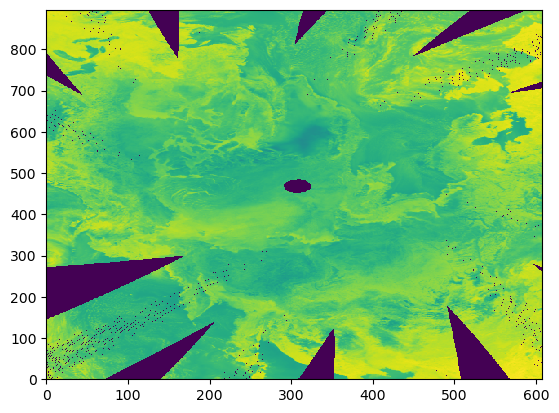

In [77]:
# open data
#----------------------------------
file = filepath+new_file
f = h5py.File(file,'r')

plt.pcolormesh(f['SI_12km_NH_89H_ASC'][:])
f.close()

## Option: create coordinate file

In [30]:
# read data into dictionary from sample file
data = read_AMSRTB_he5(file = '/Volumes/Seagate_Jewell/KenzieStuff/AMSR_TB/AMSR_U2_L3_SeaIce12km_B04_20120702.he5', hemisphere = 'N')
    
# create new dictionary with only geo data
keep_keys = ['lat', 'lon']
keep_data = {}
for key in keep_keys:
    keep_data[key] = data[key]
    
# read in cell area file
ds = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/AMSR_TB/NSIDC0771_CellArea_PS_N12.5km_v1.0.nc')
ds.close()
keep_data['area'] = ds.cell_area.values
keep_data['x'] = ds.x.values
keep_data['y'] = ds.y.values

# save data to new file
#----------------------
coord_file = f'/Volumes/Seagate_Jewell/KenzieStuff/AMSR_TB/12km_coordinates.h5'
print(f'Creating {coord_file}')
dict2hdf5(coord_file, keep_data)


Creating /Volumes/Seagate_Jewell/KenzieStuff/AMSR_TB/12km_coordinates.h5
